In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras import callbacks

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, PROJECT_ROOT)

from src.lstm_model import (build_lstm_model, mae_rmse)


PROCESSED_DIR = os.path.join(PROJECT_ROOT, "data", "processed")
FIG_DIR = os.path.join(PROJECT_ROOT, "results", "figures")
METRICS_DIR = os.path.join(PROJECT_ROOT, "results", "metrics")

os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(METRICS_DIR, exist_ok=True)

print("PROJECT_ROOT:", PROJECT_ROOT)
print("PROCESSED_DIR:", PROCESSED_DIR)

# Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

2026-02-08 22:15:47.767361: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-08 22:15:47.874281: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-08 22:15:50.467899: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


PROJECT_ROOT: /home/samanta/Desktop/pharmacy-sales-prediction-lstm-model
PROCESSED_DIR: /home/samanta/Desktop/pharmacy-sales-prediction-lstm-model/data/processed


In [2]:
daily_npz = np.load(os.path.join(PROCESSED_DIR, "daily_windows.npz"))
weekly_npz = np.load(os.path.join(PROCESSED_DIR, "weekly_windows.npz"))

X_train_d, y_train_d = daily_npz["X_train"], daily_npz["y_train"]
X_val_d, y_val_d     = daily_npz["X_val"],   daily_npz["y_val"]
X_test_d, y_test_d   = daily_npz["X_test"],  daily_npz["y_test"]

X_train_w, y_train_w = weekly_npz["X_train"], weekly_npz["y_train"]
X_val_w, y_val_w     = weekly_npz["X_val"],   weekly_npz["y_val"]
X_test_w, y_test_w   = weekly_npz["X_test"],  weekly_npz["y_test"]

print("Daily:", X_train_d.shape, X_val_d.shape, X_test_d.shape)
print("Weekly:", X_train_w.shape, X_val_w.shape, X_test_w.shape)

Daily: (1430, 30, 1) (335, 30, 1) (251, 30, 1)
Weekly: (197, 12, 1) (40, 12, 1) (29, 12, 1)


In [3]:
daily_train = pd.read_csv(os.path.join(PROCESSED_DIR, "daily_train.csv"), parse_dates=["ds"])
daily_val   = pd.read_csv(os.path.join(PROCESSED_DIR, "daily_val.csv"),   parse_dates=["ds"])
daily_test  = pd.read_csv(os.path.join(PROCESSED_DIR, "daily_test.csv"),  parse_dates=["ds"])

weekly_train = pd.read_csv(os.path.join(PROCESSED_DIR, "weekly_train.csv"), parse_dates=["ds"])
weekly_val   = pd.read_csv(os.path.join(PROCESSED_DIR, "weekly_val.csv"),   parse_dates=["ds"])
weekly_test  = pd.read_csv(os.path.join(PROCESSED_DIR, "weekly_test.csv"),  parse_dates=["ds"])

# Fit scalers on TRAIN ONLY (no leakage)
daily_scaler = MinMaxScaler().fit(daily_train[["y"]].values)
weekly_scaler = MinMaxScaler().fit(weekly_train[["y"]].values)

print("Daily scaler fitted on train:", daily_train["ds"].min(), "→", daily_train["ds"].max())
print("Weekly scaler fitted on train:", weekly_train["ds"].min(), "→", weekly_train["ds"].max())

Daily scaler fitted on train: 2014-01-02 00:00:00 → 2017-12-31 00:00:00
Weekly scaler fitted on train: 2014-01-05 00:00:00 → 2017-12-31 00:00:00


In [4]:
def plot_history(history, title, out_path):
    plt.figure()
    plt.plot(history.history["loss"], label="train_loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.tight_layout()
    plt.savefig(out_path, dpi=200)
    plt.show()
    print("Saved:", out_path)

2026-02-08 22:15:51.150355: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0160 - val_loss: 0.0084
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0095 - val_loss: 0.0085
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0093 - val_loss: 0.0084
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0091 - val_loss: 0.0084
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0091 - val_loss: 0.0084
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0090 - val_loss: 0.0084
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0091 - val_loss: 0.0084
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0091 - val_loss: 0.0084
Epoch 9/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0090 - val_loss: 0.0084
Epoch 10/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0089 - val_loss: 0.0084
Epoch 11/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0090 - val_loss: 0.0084
Epoch 12/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step

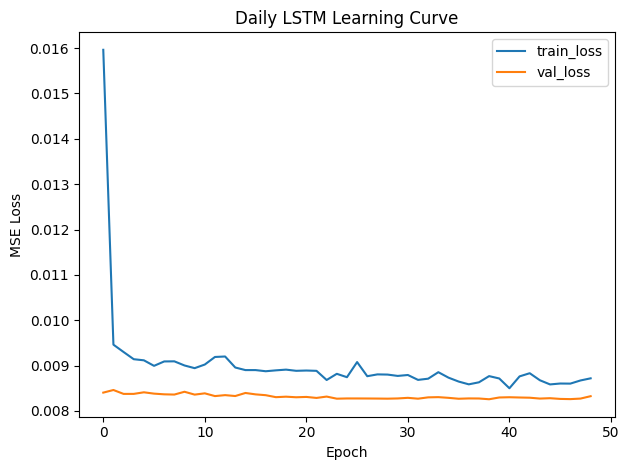

Saved: /home/samanta/Desktop/pharmacy-sales-prediction-lstm-model/results/figures/lstm_daily_learning_curve.png


In [5]:
daily_model = build_lstm_model(input_shape=X_train_d.shape[1:], units=64, dropout=0.2)
daily_model.summary()

early_stop = callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

hist_daily = daily_model.fit(
    X_train_d, y_train_d,
    validation_data=(X_val_d, y_val_d),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

plot_history(
    hist_daily,
    "Daily LSTM Learning Curve",
    os.path.join(FIG_DIR, "lstm_daily_learning_curve.png")
)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
DAILY LSTM -> MAE: 12.431078851247012 | RMSE: 16.419505723470643


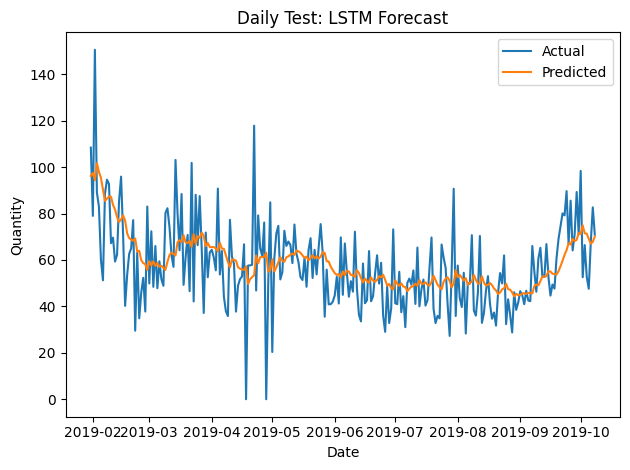

Saved: /home/samanta/Desktop/pharmacy-sales-prediction-lstm-model/results/figures/lstm_daily_test_forecast.png


In [6]:
DAILY_WINDOW = X_train_d.shape[1]

# Predict (scaled)
y_pred_d_scaled = daily_model.predict(X_test_d).flatten()

# Inverse transform to original units
y_pred_d = daily_scaler.inverse_transform(y_pred_d_scaled.reshape(-1, 1)).flatten()
y_true_d = daily_scaler.inverse_transform(y_test_d.reshape(-1, 1)).flatten()

mae_d, rmse_d = mae_rmse(y_true_d, y_pred_d)
print("DAILY LSTM -> MAE:", mae_d, "| RMSE:", rmse_d)

# Align test dates: the first DAILY_WINDOW points are not predicted
daily_test_dates = daily_test["ds"].iloc[DAILY_WINDOW:].reset_index(drop=True)

plt.figure()
plt.plot(daily_test_dates, y_true_d, label="Actual")
plt.plot(daily_test_dates, y_pred_d, label="Predicted")
plt.title("Daily Test: LSTM Forecast")
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.legend()
plt.tight_layout()
out = os.path.join(FIG_DIR, "lstm_daily_test_forecast.png")
plt.savefig(out, dpi=200)
plt.show()
print("Saved:", out)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0617 - val_loss: 0.0192
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0237 - val_loss: 0.0163
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0222 - val_loss: 0.0159
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0209 - val_loss: 0.0154
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0196 - val_loss: 0.0151
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0192 - val_loss: 0.0148
Epoch 7/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0200 - val_loss: 0.0145
Epoch 8/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0192 - val_loss: 0.0142
Epoch 9/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0192 - val_loss: 0.0140
Epoch 10/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0191 - val_loss: 0.0136
Epoch 11/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0173 - val_loss: 0.0133
Epoch 12/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

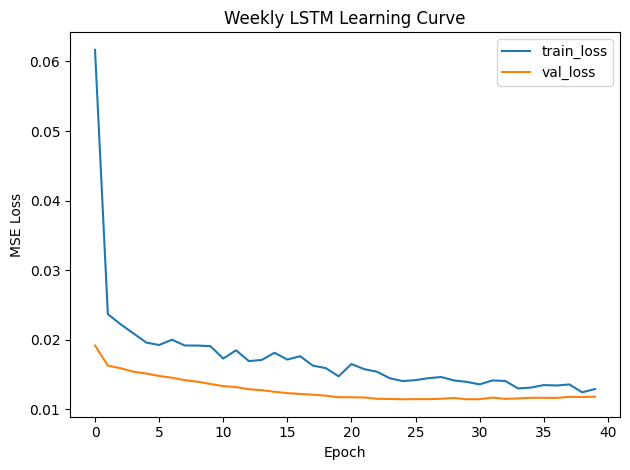

Saved: /home/samanta/Desktop/pharmacy-sales-prediction-lstm-model/results/figures/lstm_weekly_learning_curve.png


In [7]:
weekly_model = build_lstm_model(input_shape=X_train_w.shape[1:], units=64, dropout=0.2)
weekly_model.summary()

hist_weekly = weekly_model.fit(
    X_train_w, y_train_w,
    validation_data=(X_val_w, y_val_w),
    epochs=200,          # weekly has fewer samples; allow more epochs
    batch_size=16,
    callbacks=[callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)],
    verbose=1
)

plot_history(
    hist_weekly,
    "Weekly LSTM Learning Curve",
    os.path.join(FIG_DIR, "lstm_weekly_learning_curve.png")
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
WEEKLY LSTM -> MAE: 52.97634975249191 | RMSE: 78.40220494484237


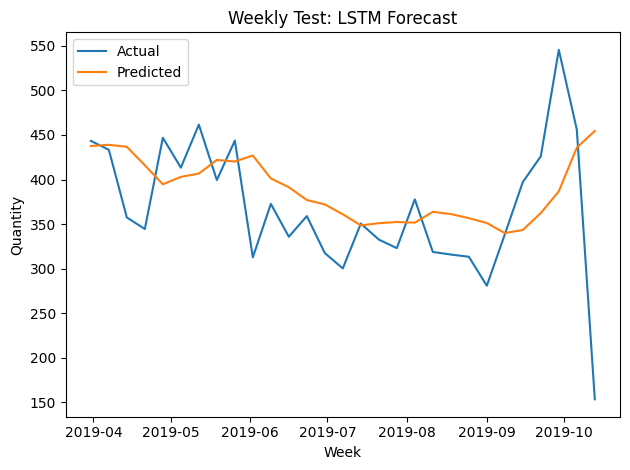

Saved: /home/samanta/Desktop/pharmacy-sales-prediction-lstm-model/results/figures/lstm_weekly_test_forecast.png


In [8]:
WEEKLY_WINDOW = X_train_w.shape[1]

y_pred_w_scaled = weekly_model.predict(X_test_w).flatten()

y_pred_w = weekly_scaler.inverse_transform(y_pred_w_scaled.reshape(-1, 1)).flatten()
y_true_w = weekly_scaler.inverse_transform(y_test_w.reshape(-1, 1)).flatten()

mae_w, rmse_w = mae_rmse(y_true_w, y_pred_w)
print("WEEKLY LSTM -> MAE:", mae_w, "| RMSE:", rmse_w)

weekly_test_dates = weekly_test["ds"].iloc[WEEKLY_WINDOW:].reset_index(drop=True)

plt.figure()
plt.plot(weekly_test_dates, y_true_w, label="Actual")
plt.plot(weekly_test_dates, y_pred_w, label="Predicted")
plt.title("Weekly Test: LSTM Forecast")
plt.xlabel("Week")
plt.ylabel("Quantity")
plt.legend()
plt.tight_layout()
out = os.path.join(FIG_DIR, "lstm_weekly_test_forecast.png")
plt.savefig(out, dpi=200)
plt.show()
print("Saved:", out)


In [9]:
# Load baseline metrics
baseline_path = os.path.join(METRICS_DIR, "baseline_metrics.csv")
baselines = pd.read_csv(baseline_path)

lstm_metrics = pd.DataFrame([
    {"model": "lstm", "granularity": "daily",  "MAE": mae_d, "RMSE": rmse_d},
    {"model": "lstm", "granularity": "weekly", "MAE": mae_w, "RMSE": rmse_w},
])

comparison = pd.concat([baselines, lstm_metrics], ignore_index=True)
display(comparison.sort_values(["granularity", "RMSE"]))

out_csv = os.path.join(METRICS_DIR, "model_comparison_metrics.csv")
comparison.to_csv(out_csv, index=False)
print("Saved:", out_csv)


,model,granularity,MAE,RMSE
4,lstm,daily,12.431079,16.419506
1,moving_avg,daily,13.183250,17.653833
0,naive,daily,17.862855,24.109943
5,lstm,weekly,52.976350,78.402205
2,naive,weekly,61.756500,82.244733
3,moving_avg,weekly,68.332266,97.567126


Saved: /home/samanta/Desktop/pharmacy-sales-prediction-lstm-model/results/metrics/model_comparison_metrics.csv


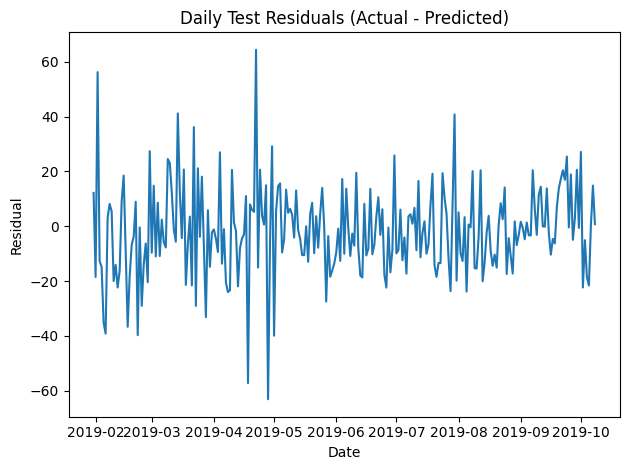

Saved: /home/samanta/Desktop/pharmacy-sales-prediction-lstm-model/results/figures/lstm_daily_residuals.png


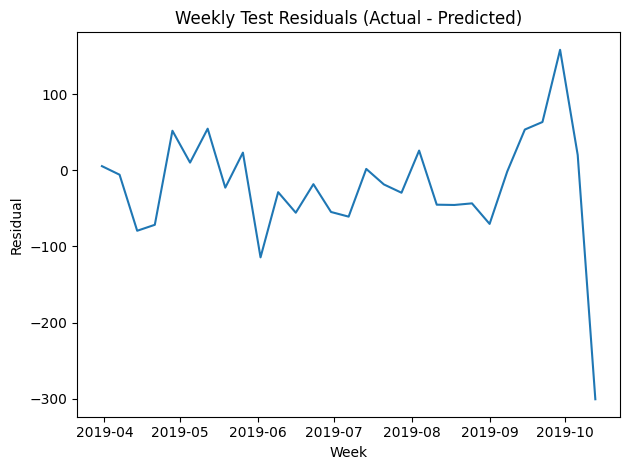

Saved: /home/samanta/Desktop/pharmacy-sales-prediction-lstm-model/results/figures/lstm_weekly_residuals.png


In [10]:
# Daily residuals
resid_d = y_true_d - y_pred_d

plt.figure()
plt.plot(daily_test_dates, resid_d)
plt.title("Daily Test Residuals (Actual - Predicted)")
plt.xlabel("Date")
plt.ylabel("Residual")
plt.tight_layout()
out = os.path.join(FIG_DIR, "lstm_daily_residuals.png")
plt.savefig(out, dpi=200)
plt.show()
print("Saved:", out)

# Weekly residuals
resid_w = y_true_w - y_pred_w

plt.figure()
plt.plot(weekly_test_dates, resid_w)
plt.title("Weekly Test Residuals (Actual - Predicted)")
plt.xlabel("Week")
plt.ylabel("Residual")
plt.tight_layout()
out = os.path.join(FIG_DIR, "lstm_weekly_residuals.png")
plt.savefig(out, dpi=200)
plt.show()
print("Saved:", out)
